# 필요 라이브러리 설치

In [3]:
!pip install gensim --upgrade
!pip install -U keras-tuner
!pip install pymysql
!pip install tensorflow

  Using cached tensorflow-2.9.1-cp38-cp38-macosx_10_14_x86_64.whl (228.5 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached typing_extensions-4.3.0-py3-none-any.whl (25 kB)
  Using cached tensorflow_io_gcs_filesystem-0.26.0-cp38-cp38-macosx_10_14_x86_64.whl (1.6 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached h5py-3.7.0-cp38-cp38-macosx_10_9_x86_64.whl (3.2 MB)
  Using cached libclang-14.0.1-py2.py3-none-macosx_10_9_x86_64.whl (13.2 MB)
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached wrapt-1.14.1-cp38-cp38-macosx_10_9_x86_64.whl (35 kB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl (438 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)


# 라이브러리 불러오기

In [1]:
import IPython
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Dense, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import pandas as pd
import numpy as np
import pymysql

# MySQL 연동

In [2]:
conn = pymysql.connect(
                        user    = '-',
                        passwd  = '-',
                        host    = "-",
                        port    = 3306,
                        db      = 'Data',
                        charset = 'utf8'
        )

# 데이터 불러오기

In [3]:
sql = 'SELECT stock_id, text, date, token, label FROM Token'
news = pd.read_sql(sql, conn)
news

/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,stock_id,text,date,token,label
0,000060,2500억 모집액 못 채우고 미달 3년물 2200억에 1710억 모집 5년물 전액 ...,2022-07-15 19:54:00,"['2500', '억', '모집', '액', '못', '채우', '고', '미달',...",1
1,000060,메리츠증권은 14일 아모레G에 대해 아모레퍼시픽 부진으로 투자 매력도가 상대적으로 ...,2022-07-14 08:36:00,"['메리츠증권', '은', '14', '일', '아모레', 'G', '에', '대하...",0
2,000060,증시 과매도 PER 종목 쏟아진다 30개 PER 1 2배로 떨어져 PER 낮은 기업...,2022-07-13 17:36:00,"['증시', '과', '매도', 'PER', '종목', '쏟아지', 'ㄴ다', '3...",1
3,000060,투자의견 매수 목표주가 7만5000원 유지 메리츠증권이 13일 SK텔레콤에 대해 2...,2022-07-13 08:18:00,"['투자', '의견', '매수', '목표', '주가', '7', '만', '5000...",0
4,000060,금감원 손보사에 유사암 일반암 진단비 자료 요구 올해들어 손보사 유사암 경쟁 진단비...,2022-07-13 06:01:00,"['금감원', '손보사', '에', '유사', '암', '일반', '암', '진단'...",0
...,...,...,...,...,...
111614,402340,앱출석 후 회원가입시 80만명 한정 선착순국내 최초 가상자산 거래소 코빗이 4월 한...,2022-04-01 11:17:00,"['앱', '출석', '후', '회원', '가', '입시', '80', '만', '...",1
111615,402340,SK그룹 투자회사 SK스퀘어의 연결대상 종속회사 원스토어와 SK쉴더스가 증권신고서를...,2022-04-01 11:06:00,"['SK', '그룹', '투자', '회사', 'SK', '스퀘어', '의', '연결...",1
111616,402340,31일 증권신고서 제출 4월 기관 수요예측 SK스퀘어 자회사들인 토종 앱스토어 원스...,2022-04-01 09:00:00,"['31', '일', '증권', '신고서', '제출', '4', '월', '기관',...",1
111617,402340,삼부토건 제3자 배정증자 방식으로 SK에코플랜트에 보통주 11만 6106주 유상증...,2022-04-01 07:01:00,"['삼부', '토건', '제', '3', '자', '배정', '증자', '방식', ...",1


# 데이터 전처리

## Token을 str -> list 형태로 변환

In [4]:
import re

def str_to_list(d):
  text = re.sub(r'[\[\'\]]', '', d)
  return text.split(", ")

news["token"] = news.token.apply(str_to_list)

## 불용어 처리

In [5]:
from tqdm import tqdm
def stopword(x):
  stopword = [r'상승.*', r'하락.*', r'급등.*', r'급락.*', '상승세', '하락세', '폭등', '폭락', '오름세', '약세', '강세', '의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다', '에', '은', '는', '하']
  return [i for i in x if i not in stopword]
tqdm.pandas()
news["token"] = news.token.progress_apply(stopword)
news

100%|██████████| 111619/111619 [00:48<00:00, 2290.52it/s]


,stock_id,text,date,token,label
0,000060,2500억 모집액 못 채우고 미달 3년물 2200억에 1710억 모집 5년물 전액 ...,2022-07-15 19:54:00,"[2500, 억, 모집, 액, 못, 채우, 고, 미달, 3, 년, 물, 2200, ...",1
1,000060,메리츠증권은 14일 아모레G에 대해 아모레퍼시픽 부진으로 투자 매력도가 상대적으로 ...,2022-07-14 08:36:00,"[메리츠증권, 14, 일, 아모레, G, 대하, 어, 아모레, 퍼시픽, 부진, 투자...",0
2,000060,증시 과매도 PER 종목 쏟아진다 30개 PER 1 2배로 떨어져 PER 낮은 기업...,2022-07-13 17:36:00,"[증시, 매도, PER, 종목, 쏟아지, ㄴ다, 30, 개, PER, 1, 2, 배...",1
3,000060,투자의견 매수 목표주가 7만5000원 유지 메리츠증권이 13일 SK텔레콤에 대해 2...,2022-07-13 08:18:00,"[투자, 의견, 매수, 목표, 주가, 7, 만, 5000, 원, 유지, 메리츠증권,...",0
4,000060,금감원 손보사에 유사암 일반암 진단비 자료 요구 올해들어 손보사 유사암 경쟁 진단비...,2022-07-13 06:01:00,"[금감원, 손보사, 유사, 암, 일반, 암, 진단, 비, 자료, 요구, 올해, 듣,...",0
...,...,...,...,...,...
111614,402340,앱출석 후 회원가입시 80만명 한정 선착순국내 최초 가상자산 거래소 코빗이 4월 한...,2022-04-01 11:17:00,"[앱, 출석, 후, 회원, 입시, 80, 만, 명, 한정, 선착순, 국내, 최초, ...",1
111615,402340,SK그룹 투자회사 SK스퀘어의 연결대상 종속회사 원스토어와 SK쉴더스가 증권신고서를...,2022-04-01 11:06:00,"[SK, 그룹, 투자, 회사, SK, 스퀘어, 연결, 대상, 종속, 회사, 원, 스...",1
111616,402340,31일 증권신고서 제출 4월 기관 수요예측 SK스퀘어 자회사들인 토종 앱스토어 원스...,2022-04-01 09:00:00,"[31, 일, 증권, 신고서, 제출, 4, 월, 기관, 수요, 예측, SK, 스퀘어...",1
111617,402340,삼부토건 제3자 배정증자 방식으로 SK에코플랜트에 보통주 11만 6106주 유상증...,2022-04-01 07:01:00,"[삼부, 토건, 제, 3, 배정, 증자, 방식, SK, 에코, 플랜트, 보통주, 1...",1


# 모델링

## 데이터 셋 나누기

In [6]:
train = news.loc[news["date"] >= '2022-07-01 00:00:00']
test = news.loc[news["date"] < '2022-07-01 00:00:00']

X_train = train['token']
y_train = train['label']
X_test = test['token']
y_test = test['label']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(16701,) (16701,) (94918,) (94918,)


## Tokenizer

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [8]:
threshold = 3
words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  words_freq += value

  if value < threshold:
    rare_cnt +=1
    rare_freq += value

print("전체 단어 수", words_cnt)
print("빈도가 {} 이하인 희귀 단어 수: {}".format(threshold-1, rare_cnt))
print("희귀 단어 비율: {}".format((rare_cnt / words_cnt) * 100))
print("희귀 단어 등장 빈도 비율: {}".format((rare_freq / words_freq) * 100))

전체 단어 수 38853
빈도가 2 이하인 희귀 단어 수: 9607
희귀 단어 비율: 24.72653334362855
희귀 단어 등장 빈도 비율: 0.15803616408697888


In [9]:
vocab_size = words_cnt - rare_cnt + 2
print(vocab_size)

29248


In [10]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [11]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [12]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_trian = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

16701
16701


/opt/anaconda3/envs/jupyter/lib/python3.8/site-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [13]:
print('리뷰 최대 길이:', max(len(l) for l in X_train))
print('리뷰 평균 길이:', sum(map(len, X_trian)) / len(X_train))

리뷰 최대 길이: 3992
리뷰 평균 길이: 523.9144961379558


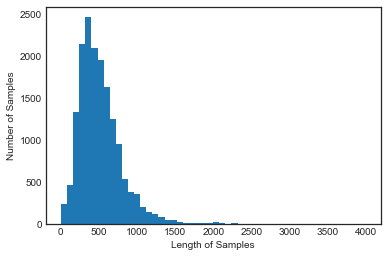

In [14]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('Length of Samples')
plt.ylabel('Number of Samples')
plt.show()

In [15]:
max_len = 1500

In [16]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [17]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(Embedding(vocab_size, 100))
  hp_units1 = hp.Int('units1', min_value = 32, max_value = 512, step = 32)
  model.add(Bidirectional(GRU(units = hp_units1, return_sequences = True)))
  hp_units2 = hp.Int('units2', min_value = 32, max_value = 512, step = 32)
  model.add(Bidirectional(GRU(units = hp_units2, return_sequences = True)))
  hp_units3 = hp.Int('units3', min_value = 32, max_value = 512, step = 32)
  model.add(Bidirectional(GRU(units = hp_units3)))
  model.add(Dense(1, activation='sigmoid'))

  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
  model.compile(optimizer = keras.optimizers.Nadam(learning_rate = hp_learning_rate),
                loss = keras.losses.BinaryCrossentropy(), 
                metrics = ['accuracy'])
  
  return model

In [18]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir/intro_to_kt/oracle.json


2022-07-31 22:21:35.077975: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [20]:
tuner.search(X_train, y_train, epochs = 10, validation_data = (X_test, y_test), callbacks = [ClearTrainingOutput()])

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
하이퍼 파라미터 검색이 완료되었습니다. 
최적화된 첫 번째 GRU 노드 수는 {best_hps.get('units1')} 입니다.
최적화된 두 번째 GRU 노드 수는 {best_hps.get('units2')} 입니다.
최적화된 세 번째 GRU 노드 수는 {best_hps.get('units3')} 입니다.
최적의 학습 속도는 {best_hps.get('learning_rate')} 입니다.
""")


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
256               |?                 |units1
448               |?                 |units2
160               |?                 |units3
0.0001            |?                 |learning_rate
2                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
2                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Epoch 1/2
 17/522 [..............................] - ETA: 3:13:00 - loss: 0.6935 - accuracy: 0.4963

KeyboardInterrupt: 